Παρακάτω προσπαθώ να παρουσιάσω την ανάλυση του *Hogg et al 2010 - Data analysis Recipes* η οποία μας λέει από το abstract:

Χρησιμοποιούμε πάρα πολλές *considerations involved* ώστε να προσαρμόσουμε ένα μοντέλο σε δεδομένα, όπως για παράδειγμα τη προσαρμογή μιας ευθείας σε σημεία δύο διαστάσεων. Η standard μέθοδος των ελαχίστων τετραγώνων (wls) θεωρεί οτι τα σφάλματα των σημείων στη μια διάσταση είναι *neglible* ενώ στην άλλη περιγράφονται απο Gaussians με γνωστή απόκλιση, υποθέσεις που στη πραγματικότητα συναντώνται εξαιρετικά σπάνια. 

Θεωρούμε τη περίπτωση ενός ετερογενούς δείγματος δεδομένων με άγνωστα σφάλματα σε δύο διαστάσεις και περιπτώσεις όπου συμπεριλαμβάνονται κακά δεδομένα (outliers) τα οποία εμφανίζουν γραμμική συσχέτιση.

*Above all we emphasize the importance of having a “generative model” for the data, even an approx-
imate one. Once there is a generative model, the subsequent fitting
is non-arbitrary because the model permits direct computation of the
likelihood of the parameters or the posterior probability distribution.
Construction of a posterior probability distribution is indispensible if
there are “nuisance parameters” to marginalize away.*

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
rc('text', usetex=True)
rcParams['figure.figsize'] = (8, 6.5)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['axes.titlesize']=20.
rcParams['text.latex.preamble'] = ['\\usepackage{siunitx}']
import seaborn
seaborn.despine()
seaborn.set_style('white', {'axes.linewidth': 0.5, 'axes.edgecolor':'black'})
seaborn.despine(left=True)
%load_ext autoreload
from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test
from astropy.table import Table
from scipy import polyfit,linalg
from scipy.optimize import curve_fit

Η βιβλιοθήκη astroML (που μπορει να εγκατασταθεί έυκολα μέσω της ```sudo pip install astroml``` εμπεριέχει τα δεδομένα που χρησιμοποιούνται στο paper. Παρόλαυτα όποιος τα θέλει αλλιώς ή δεν θέλει/μπορεί να εγκαταστήσει τη βιβλιοθήκη μπορεί να μου τα ζητήσει.

In [4]:
data = fetch_hogg2010test()
data = data[5:]  # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

In [5]:
np.savetxt('data',data)

In [6]:
t = Table([x, y, sigma_x,sigma_y,rho_xy], names=('X', 'Y', '$\sigma _x$','$\sigma _y$','$\\rho _{xy}$'))#, meta={'name': 'first table'})
t

X,Y,$\sigma _x$,$\sigma _y$,$\rho _{xy}$
float64,float64,float64,float64,float64
58.0,173.0,9.0,15.0,0.67
210.0,479.0,4.0,27.0,-0.02
202.0,504.0,4.0,14.0,-0.05
198.0,510.0,11.0,30.0,-0.84
158.0,416.0,7.0,16.0,-0.69
165.0,393.0,5.0,14.0,0.3
201.0,442.0,5.0,25.0,-0.46
157.0,317.0,5.0,52.0,-0.03
131.0,311.0,6.0,16.0,0.5


<Container object of 3 artists>

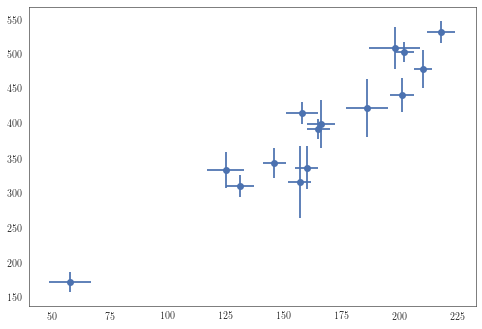

In [7]:
plt.errorbar(x,y,yerr=sigma_y,xerr=sigma_x,fmt='o')

Έχουμε ένα σύνολο $N>2$ σημείων $(x_i,y_i)$ με γνωστές gaussian αποκλίσεις $\sigma _{yi}$ στη $y$ διεύθυνση και χωρίς καμία απροσδιοριστία στη $x$ διεύθυνση.

Αναζητούμε τη συνάρτηση $f(x)$ της μορφής: $ f(x)=m x+b $ η οποία προσαρμόζεται καλύτερα στα σημεία.

Κατασκευάζουμε τους πίνακες 
\begin{align}
\mathbf{Y}&=\begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_N\end{pmatrix} \\
\mathbf{A}&=\begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_N \end{pmatrix} \\
\mathbf{C}&=\begin{pmatrix} 
\frac{1}{\sigma ^2_{y1}} & 0 & 0 & \cdots & 0 \\ 
0 & \frac{1}{\sigma ^2_{y2}} & 0 & \cdots & 0 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
0 & 0 & 0 & \cdots & \frac{1}{\sigma ^2_{yN}} \end{pmatrix}
\end{align}

Η λύση καλύτερης προσαρμογης δίνεται από τη:
\begin{equation}
\begin{pmatrix} b \\ m \end{pmatrix} = \mathbf{S}= [\mathbf{A}^T \mathbf{C} \mathbf{A}]^{-1} [\mathbf{A}^T \mathbf{C} \mathbf{Y}]
\end{equation}

In [8]:
Y=y
A=np.stack((np.ones(x.shape[0]),x),axis=-1)
C=np.diagflat(1./sigma_y**2)

In [9]:
first=np.linalg.inv(A.T.dot(C.dot(A)))
second=A.T.dot(C.dot(Y))
M=np.dot(first,second)
print M

[ 34.84594131   2.23253622]


***Ερώτηση:*** Πως μπορούμε να υπολογίσουμε τα σφάλματα μέσω αναλυτικής έκφρασης?

## Εκτίμηση των παραμέτρων προσαρμογής μέσω optimization
Μέσω της βιβλιοθήκης ```scipy.optimization```

[ 34.84594131   2.23253622] [ 22.02571655   0.13189614]
Y=(34.8 +- 22.0) + (2.2 +- 0.13) X


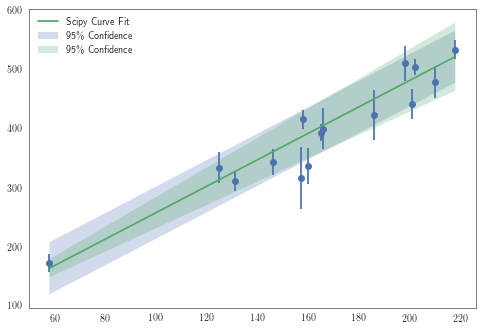

In [10]:
def f(x,b,m): return b+m*x
Mcf,dMcf2=curve_fit(f,x,y,[2.,30.],sigma=sigma_y)
dMcf=np.sqrt(np.diag(dMcf2))
print Mcf, dMcf
print 'Y=({:.1f} +- {:.1f}) + ({:.1f} +- {:.2f}) X'.format(Mcf[0],dMcf[0],Mcf[1],dMcf[1])
xx=np.linspace(x.min(),x.max())
plt.errorbar(x,y,yerr=sigma_y,fmt='o')
plt.plot(xx,f(xx,Mcf[0],Mcf[1]),label='Scipy Curve Fit')
plt.fill_between(xx,f(xx,Mcf[0]-2.*dMcf[0],Mcf[1]),f(xx,Mcf[0]+2.*dMcf[0],Mcf[1]),alpha=0.25,label='95\% Confidence')
plt.fill_between(xx,f(xx,Mcf[0],Mcf[1]-2.*dMcf[1]),f(xx,Mcf[0],Mcf[1]+2.*dMcf[1]),alpha=0.25,label='95\% Confidence')
plt.legend(loc='best')

18.5852705329 166.429861153


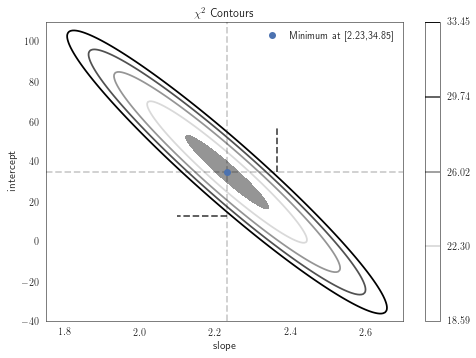

In [11]:
NN=200
bb=np.linspace(-40,110,NN)
mm=np.linspace(1.75,2.7,NN)
LogL=np.zeros((len(bb),len(mm)))
for i,b in enumerate(bb):
    for j,m in enumerate(mm):
        LogL[i,j]=np.sum((y-f(x,b,m))**2/sigma_y**2)
print LogL.min(),LogL.mean()
ax=plt.subplot()
c=ax.contour(LogL,np.linspace(LogL.min(),1.8*LogL.min(),5),extent=[mm.min(),mm.max(),bb.min(),bb.max()])
c2=ax.contourf(LogL,[LogL.min(),LogL.min()+1.],extent=[mm.min(),mm.max(),bb.min(),bb.max()],label='$\chi ^2+1$')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.vlines(Mcf[1],bb.min(),bb.max(),linestyles='--',alpha=0.2)
ax.hlines(Mcf[0],mm.min(),mm.max(),linestyles='--',alpha=0.2)
ax.vlines(Mcf[1]+dMcf[1],Mcf[0],Mcf[0]+dMcf[0],linestyles='--',alpha=0.7)#,label=r'Intercept $\sigma$')
ax.hlines(Mcf[0]-dMcf[0],Mcf[1],Mcf[1]-dMcf[1],linestyles='--',alpha=0.7)#,label=r'Slope $\sigma$')
ax.plot([Mcf[1]],[Mcf[0]],'o',label='Minimum at [{:.2f},{:.2f}]'.format(Mcf[1],Mcf[0]))
ax.set_title('$\chi ^2$ Contours')
plt.colorbar(c,ax=ax)
ax.legend()

Εδώ προσπαθώ να υπολογίσω τη παράμετρο p. Η παράμετρος p ουσιαστικά είναι η πιθανότητα η κάθε παράμετρος να μην παίζει ρόλο. Δηλαδή αν για παράδειγμα η ευθεία ειχε κλίση αλλα το σφάλμα της κλίση είναι μέγαλο τότε υπάρχει μια πιθανότητα η κλιση να είναι 0 άρα ουσιαστικά τα δεδομένα να μην έχουν αυτο το βαθμό ελευθερίας που εμεις θεωρούμε.
Τέλος Πάντων είναι λίγο άσχετο με την όλη θεματολογια και μπορεί να το βγάλω στο τέλος.

In [12]:
N=len(x)
d=N-2
s=np.random.standard_t(d, size=100000)
tt=np.array([Mcf[0]/dMcf[0]/np.sqrt(N),Mcf[1]/dMcf[1]/np.sqrt(N)])
print np.sum(s>tt[0])/float(len(s))+np.sum(s<-tt[0])/float(len(s))
print np.sum(s>tt[1])/float(len(s))+np.sum(s<-tt[1])/float(len(s))

0.68956
0.00075


[  7.25765066e+01   1.60453031e+00   2.25414567e-03] [  4.68743539e+01   7.00142302e-01   2.46748890e-03]
Y=(72.6 +- 46.9) + (1.6 +- 0.70) X+(0.002 +- 0.0025) X^2


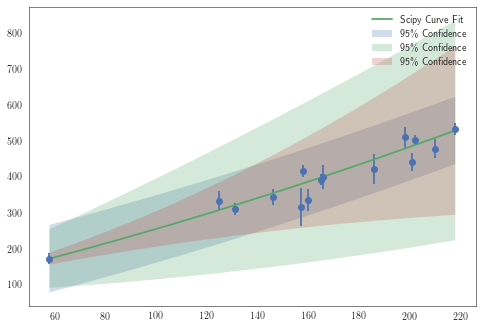

In [13]:
def f2(x,b,m1,m2): return b+m1*x+m2*x**2
M2cf,dM2cf2=curve_fit(f2,x,y,[2.,30.,2],sigma=sigma_y)
dM2cf=np.sqrt(np.diag(dM2cf2))
print M2cf, dM2cf
print 'Y=({:.1f} +- {:.1f}) + ({:.1f} +- {:.2f}) X+({:.3f} +- {:.4f}) X^2'.format(M2cf[0],dM2cf[0],M2cf[1],dM2cf[1],M2cf[2],dM2cf[2])
xx=np.linspace(x.min(),x.max())
plt.errorbar(x,y,yerr=sigma_y,fmt='o')
plt.plot(xx,f2(xx,M2cf[0],M2cf[1],M2cf[2]),label='Scipy Curve Fit')
plt.fill_between(xx,f2(xx,M2cf[0]-2.*dM2cf[0],M2cf[1],M2cf[2]),f2(xx,M2cf[0]+2.*dM2cf[0],M2cf[1],M2cf[2]),alpha=0.25,label='95\% Confidence')
plt.fill_between(xx,f2(xx,M2cf[0],M2cf[1]-2.*dM2cf[1],M2cf[2]),f2(xx,M2cf[0],M2cf[1]+2.*dM2cf[1],M2cf[2]),alpha=0.25,label='95\% Confidence')
plt.fill_between(xx,f2(xx,M2cf[0],M2cf[1],M2cf[2]-2.*dM2cf[2]),f2(xx,M2cf[0],M2cf[1],M2cf[2]+2.*dM2cf[2]),alpha=0.25,label='95\% Confidence')
plt.legend(loc='best')
#plt.ylim([0,700])

[ 0.39977454  0.59171963  0.23587458]
0.69528
0.56384
0.81675


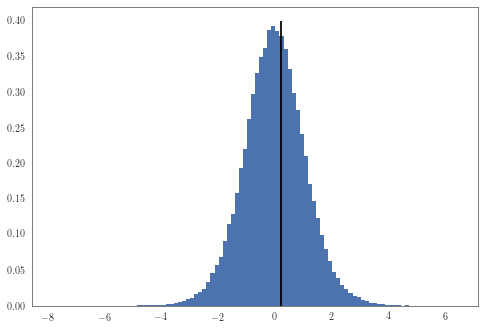

In [14]:
N=x.shape[0]
d=N-3
s=np.random.standard_t(d, size=100000)
tt2=np.array([M2cf[0]/dM2cf[0]/np.sqrt(N),M2cf[1]/dM2cf[1]/np.sqrt(N),M2cf[2]/dM2cf[2]/np.sqrt(N)])
plt.hist(s, bins=100, normed=True)
plt.vlines(tt2[2],0,0.4)
print tt2
print np.sum(s>tt2[0])/float(len(s))+np.sum(s<-tt2[0])/float(len(s))
print np.sum(s>tt2[1])/float(len(s))+np.sum(s<-tt2[1])/float(len(s))
print np.sum(s>tt2[2])/float(len(s))+np.sum(s<-tt2[2])/float(len(s))

# Data with outliers

<Container object of 3 artists>

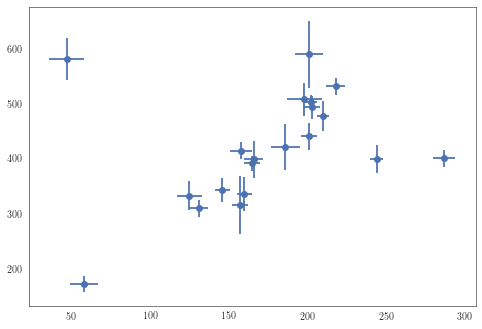

In [15]:
data = fetch_hogg2010test()
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']
plt.errorbar(x,y,yerr=sigma_y,xerr=sigma_x,fmt='o')

[ 213.273495      1.07674751] [ 57.77208931   0.31068093]
Y=(213.3 +- 57.8) + (1.1 +- 0.31) X


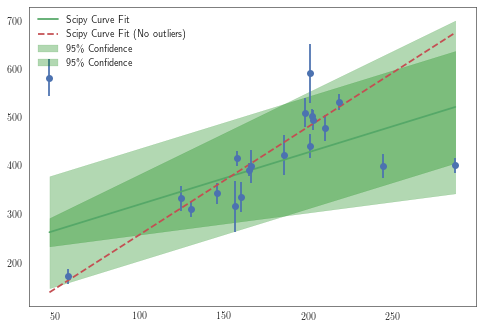

In [16]:
Mcft,dMcf2t=curve_fit(f,x,y,[2.,30.],sigma=sigma_y)
dMcft=np.sqrt(np.diag(dMcf2t))
print Mcft, dMcft
print 'Y=({:.1f} +- {:.1f}) + ({:.1f} +- {:.2f}) X'.format(Mcft[0],dMcft[0],Mcft[1],dMcft[1])
xx=np.linspace(x.min(),x.max())
plt.errorbar(x,y,yerr=sigma_y,fmt='o')
plt.plot(xx,f(xx,Mcft[0],Mcft[1]),label='Scipy Curve Fit')
plt.fill_between(xx,f(xx,Mcft[0]-2.*dMcft[0],Mcft[1]),f(xx,Mcft[0]+2.*dMcft[0],Mcft[1]),color='g',alpha=0.3,label='95\% Confidence')
plt.fill_between(xx,f(xx,Mcft[0],Mcft[1]-2.*dMcft[1]),f(xx,Mcft[0],Mcft[1]+2.*dMcft[1]),color='g',alpha=0.3,label='95\% Confidence')
plt.plot(xx,f(xx,Mcf[0],Mcf[1]),'--',label='Scipy Curve Fit (No outliers)')
plt.legend(loc='best')

289.98821958 1303.37019082


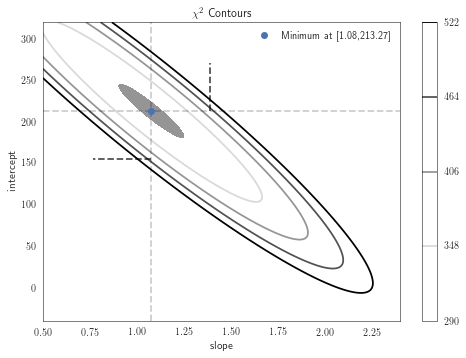

In [17]:
N=200
bb=np.linspace(-40,320,N)
mm=np.linspace(0.5,2.4,N)
LogL=np.zeros((len(bb),len(mm)))
for i,b in enumerate(bb):
    for j,m in enumerate(mm):
        LogL[i,j]=np.sum((y-f(x,b,m))**2/sigma_y**2)
print LogL.min(),LogL.mean()
ax=plt.subplot()
c=ax.contour(LogL,np.linspace(LogL.min(),1.8*LogL.min(),5),extent=[mm.min(),mm.max(),bb.min(),bb.max()])
c2=ax.contourf(LogL,[LogL.min(),LogL.min()+5],extent=[mm.min(),mm.max(),bb.min(),bb.max()],label='$\chi ^2+1$')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.vlines(Mcft[1],bb.min(),bb.max(),linestyles='--',alpha=0.2)
ax.hlines(Mcft[0],mm.min(),mm.max(),linestyles='--',alpha=0.2)
ax.vlines(Mcft[1]+dMcft[1],Mcft[0],Mcft[0]+dMcft[0],linestyles='--',alpha=0.7)#,label=r'Intercept $\sigma$')
ax.hlines(Mcft[0]-dMcft[0],Mcft[1],Mcft[1]-dMcft[1],linestyles='--',alpha=0.7)#,label=r'Slope $\sigma$')
ax.plot([Mcft[1]],[Mcft[0]],'o',label='Minimum at [{:.2f},{:.2f}]'.format(Mcft[1],Mcft[0]))
ax.set_title('$\chi ^2$ Contours')
plt.colorbar(c,ax=ax)
ax.legend()

[  1.88458019e+01   3.71596638e+00  -7.80682007e-03] [  9.72646331e+01   1.15305514e+00   3.31049078e-03]
Y=(18.8 +- 97.3) + (3.7 +- 1.15) X+(-0.008 +- 0.0033) X^2


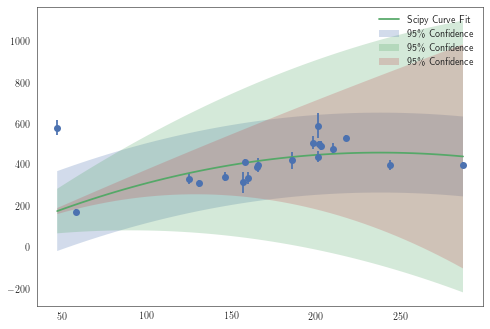

In [18]:
def f2(x,b,m1,m2): return b+m1*x+m2*x**2
M2cf,dM2cf2=curve_fit(f2,x,y,[2.,30.,2],sigma=sigma_y)
dM2cf=np.sqrt(np.diag(dM2cf2))
print M2cf, dM2cf
print 'Y=({:.1f} +- {:.1f}) + ({:.1f} +- {:.2f}) X+({:.3f} +- {:.4f}) X^2'.format(M2cf[0],dM2cf[0],M2cf[1],dM2cf[1],M2cf[2],dM2cf[2])
xx=np.linspace(x.min(),x.max())
plt.errorbar(x,y,yerr=sigma_y,fmt='o')
plt.plot(xx,f2(xx,M2cf[0],M2cf[1],M2cf[2]),label='Scipy Curve Fit')
plt.fill_between(xx,f2(xx,M2cf[0]-2.*dM2cf[0],M2cf[1],M2cf[2]),f2(xx,M2cf[0]+2.*dM2cf[0],M2cf[1],M2cf[2]),alpha=0.25,label='95\% Confidence')
plt.fill_between(xx,f2(xx,M2cf[0],M2cf[1]-2.*dM2cf[1],M2cf[2]),f2(xx,M2cf[0],M2cf[1]+2.*dM2cf[1],M2cf[2]),alpha=0.25,label='95\% Confidence')
plt.fill_between(xx,f2(xx,M2cf[0],M2cf[1],M2cf[2]-2.*dM2cf[2]),f2(xx,M2cf[0],M2cf[1],M2cf[2]+2.*dM2cf[2]),alpha=0.25,label='95\% Confidence')
plt.legend(loc='best')
#plt.ylim([0,700])